                            OLS Regression Results                            
Dep. Variable:            Revenue_Log   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     94.86
Date:                Sat, 01 Apr 2023   Prob (F-statistic):           1.85e-14
Time:                        18:07:54   Log-Likelihood:                -128.58
No. Observations:                  69   AIC:                             261.2
Df Residuals:                      67   BIC:                             265.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         14.3160      0.806     17.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17316\1464358194.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Firm_copy.insert(Firm_copy.columns.get_loc('Revenue'),'Revenue_Log', series_Revenue_Log)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17316\1464358194.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Firm_copy.insert(Firm_copy.columns.get_loc('Num_Employ'),'Num_Employ_Log', series_Num_Employ_Log)


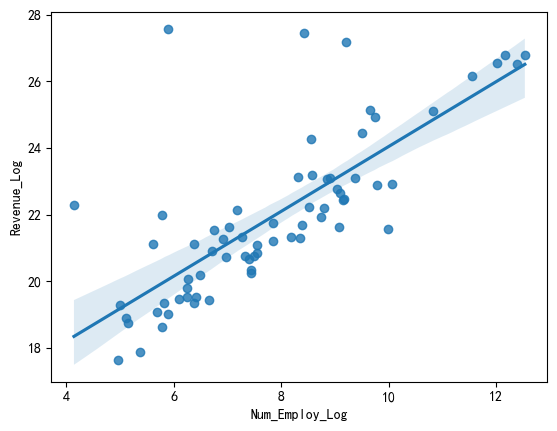

In [1]:
import pandas as pd
import numpy as np
import math
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = 'SimHei'

# init graph bom
BomNodes = pd.read_csv('BomNodes.csv', index_col=0)
BomNodes.set_index('Code', inplace=True)
BomCateNet = pd.read_csv('BomCateNet.csv', index_col=0)
BomCateNet.fillna(0, inplace=True)

G = nx.from_pandas_adjacency(BomCateNet, create_using=nx.MultiDiGraph())

labels_dict = {}
for code in G.nodes:
    labels_dict[code] = BomNodes.loc[code].to_dict()
nx.set_node_attributes(G, labels_dict)

# load firm
Firm = pd.read_csv("Firm.csv")
Firm_copy = Firm.copy()

# add attribute, number of firm, to graph bom
firm_num_dict = {}
for node in nx.nodes(G):
    firm_num_dict[node]= sum(Firm_copy[node]==1)
nx.set_node_attributes(G, firm_num_dict, name="Num_Firm")

# get log revenue
Firm_copy['Revenue_Log'] = Firm_copy['Revenue'].map(math.log)
Firm_copy['Num_Employ_Log'] = Firm_copy['Num_Employ'].map(math.log)
data_ols = Firm_copy[Firm_copy[['Revenue_Log', 'Num_Employ_Log']].notnull().all(axis=1)][['Revenue_Log', 'Num_Employ_Log']]

ols_model = smf.ols('Revenue_Log ~ Num_Employ_Log', data=data_ols)
ols_results = ols_model.fit()
b = ols_results.params.Intercept
a = ols_results.params.Num_Employ_Log
print(ols_results.summary())
sns.regplot(x='Num_Employ_Log',y='Revenue_Log',data=data_ols[data_ols.notnull().all(axis=1)])

Firm_copy.loc[Firm_copy['Revenue_Log'].isnull(), 'Revenue_Log'] = Firm_copy[Firm_copy['Revenue_Log'].isnull()]['Num_Employ_Log'].map(lambda x: a*x + b)
series_Revenue_Log = Firm_copy.pop('Revenue_Log')
Firm_copy.insert(Firm_copy.columns.get_loc('Revenue'),'Revenue_Log', series_Revenue_Log)
series_Num_Employ_Log = Firm_copy.pop('Num_Employ_Log')
Firm_copy.insert(Firm_copy.columns.get_loc('Num_Employ'),'Num_Employ_Log', series_Num_Employ_Log)

# lift firm from neighboring tier
node_list = list(nx.bfs_tree(G, '1'))
node_list.reverse()

# init criterion for ending the lifting process
node_check = [k for k, v in nx.get_node_attributes(G, 'Num_Firm').items() if v==0]
if '1' in node_check:
    node_check.remove('1')
for node in node_check:
    if G.out_degree(node) == 0:
        node_check.remove(node)
        print(f"Warning: node, {node}, in tier 0 does not contain firm")

while node_check:
    for node in node_list[:-1]:
        if G.out_degree(node) > 0 and sum(Firm_copy[node]==1) == 0:
            list_neighbors = list(G.neighbors(node))
            firm_list = Firm_copy.index[(Firm_copy[list_neighbors]==1).all(axis=1)].to_list()
            if firm_list: # there exist firm that produces all components
                # lift firm with size above average in firm_list
                average_size = Firm_copy.loc[firm_list, 'Revenue_Log'].mean()
                firm_selected_list = Firm_copy.loc[firm_list].loc[Firm_copy.loc[firm_list, 'Revenue_Log'] >= average_size].index.to_list()
                Firm_copy.loc[firm_selected_list, node] = 1
                Firm_copy.loc[firm_selected_list, list_neighbors] = np.nan
            else: # select top 15% firm in terms of size
                firm_list = Firm_copy.index[(Firm_copy[list_neighbors]==1).any(axis=1)].to_list()
                firm_df = Firm_copy.loc[firm_list].sort_values('Revenue_Log', ascending=False)
                num_firm_selected = round(firm_df.shape[0] * 0.15)
                firm_selected_list = firm_df.index[0: num_firm_selected].to_list()
                Firm_copy.loc[firm_selected_list, node] = 1
                Firm_copy.loc[firm_selected_list, list_neighbors] = np.nan

    # update attribute, number of firm
    for node in nx.nodes(G):
        firm_num_dict[node]= sum(Firm_copy[node]==1)
    nx.set_node_attributes(G, firm_num_dict, name="Num_Firm")

    # update criterion for ending the lifting process
    node_check = [k for k, v in nx.get_node_attributes(G, 'Num_Firm').items() if v==0]
    if '1' in node_check:
        node_check.remove('1')
    for node in node_check:
        if G.out_degree(node) == 0:
            node_check.remove(node)
            print(f"Warning: node, {node}, in tier 0 does not contain firm")

# output
# Firm_copy.to_csv('Firm_amended.csv', index=False, encoding='utf-8-sig')

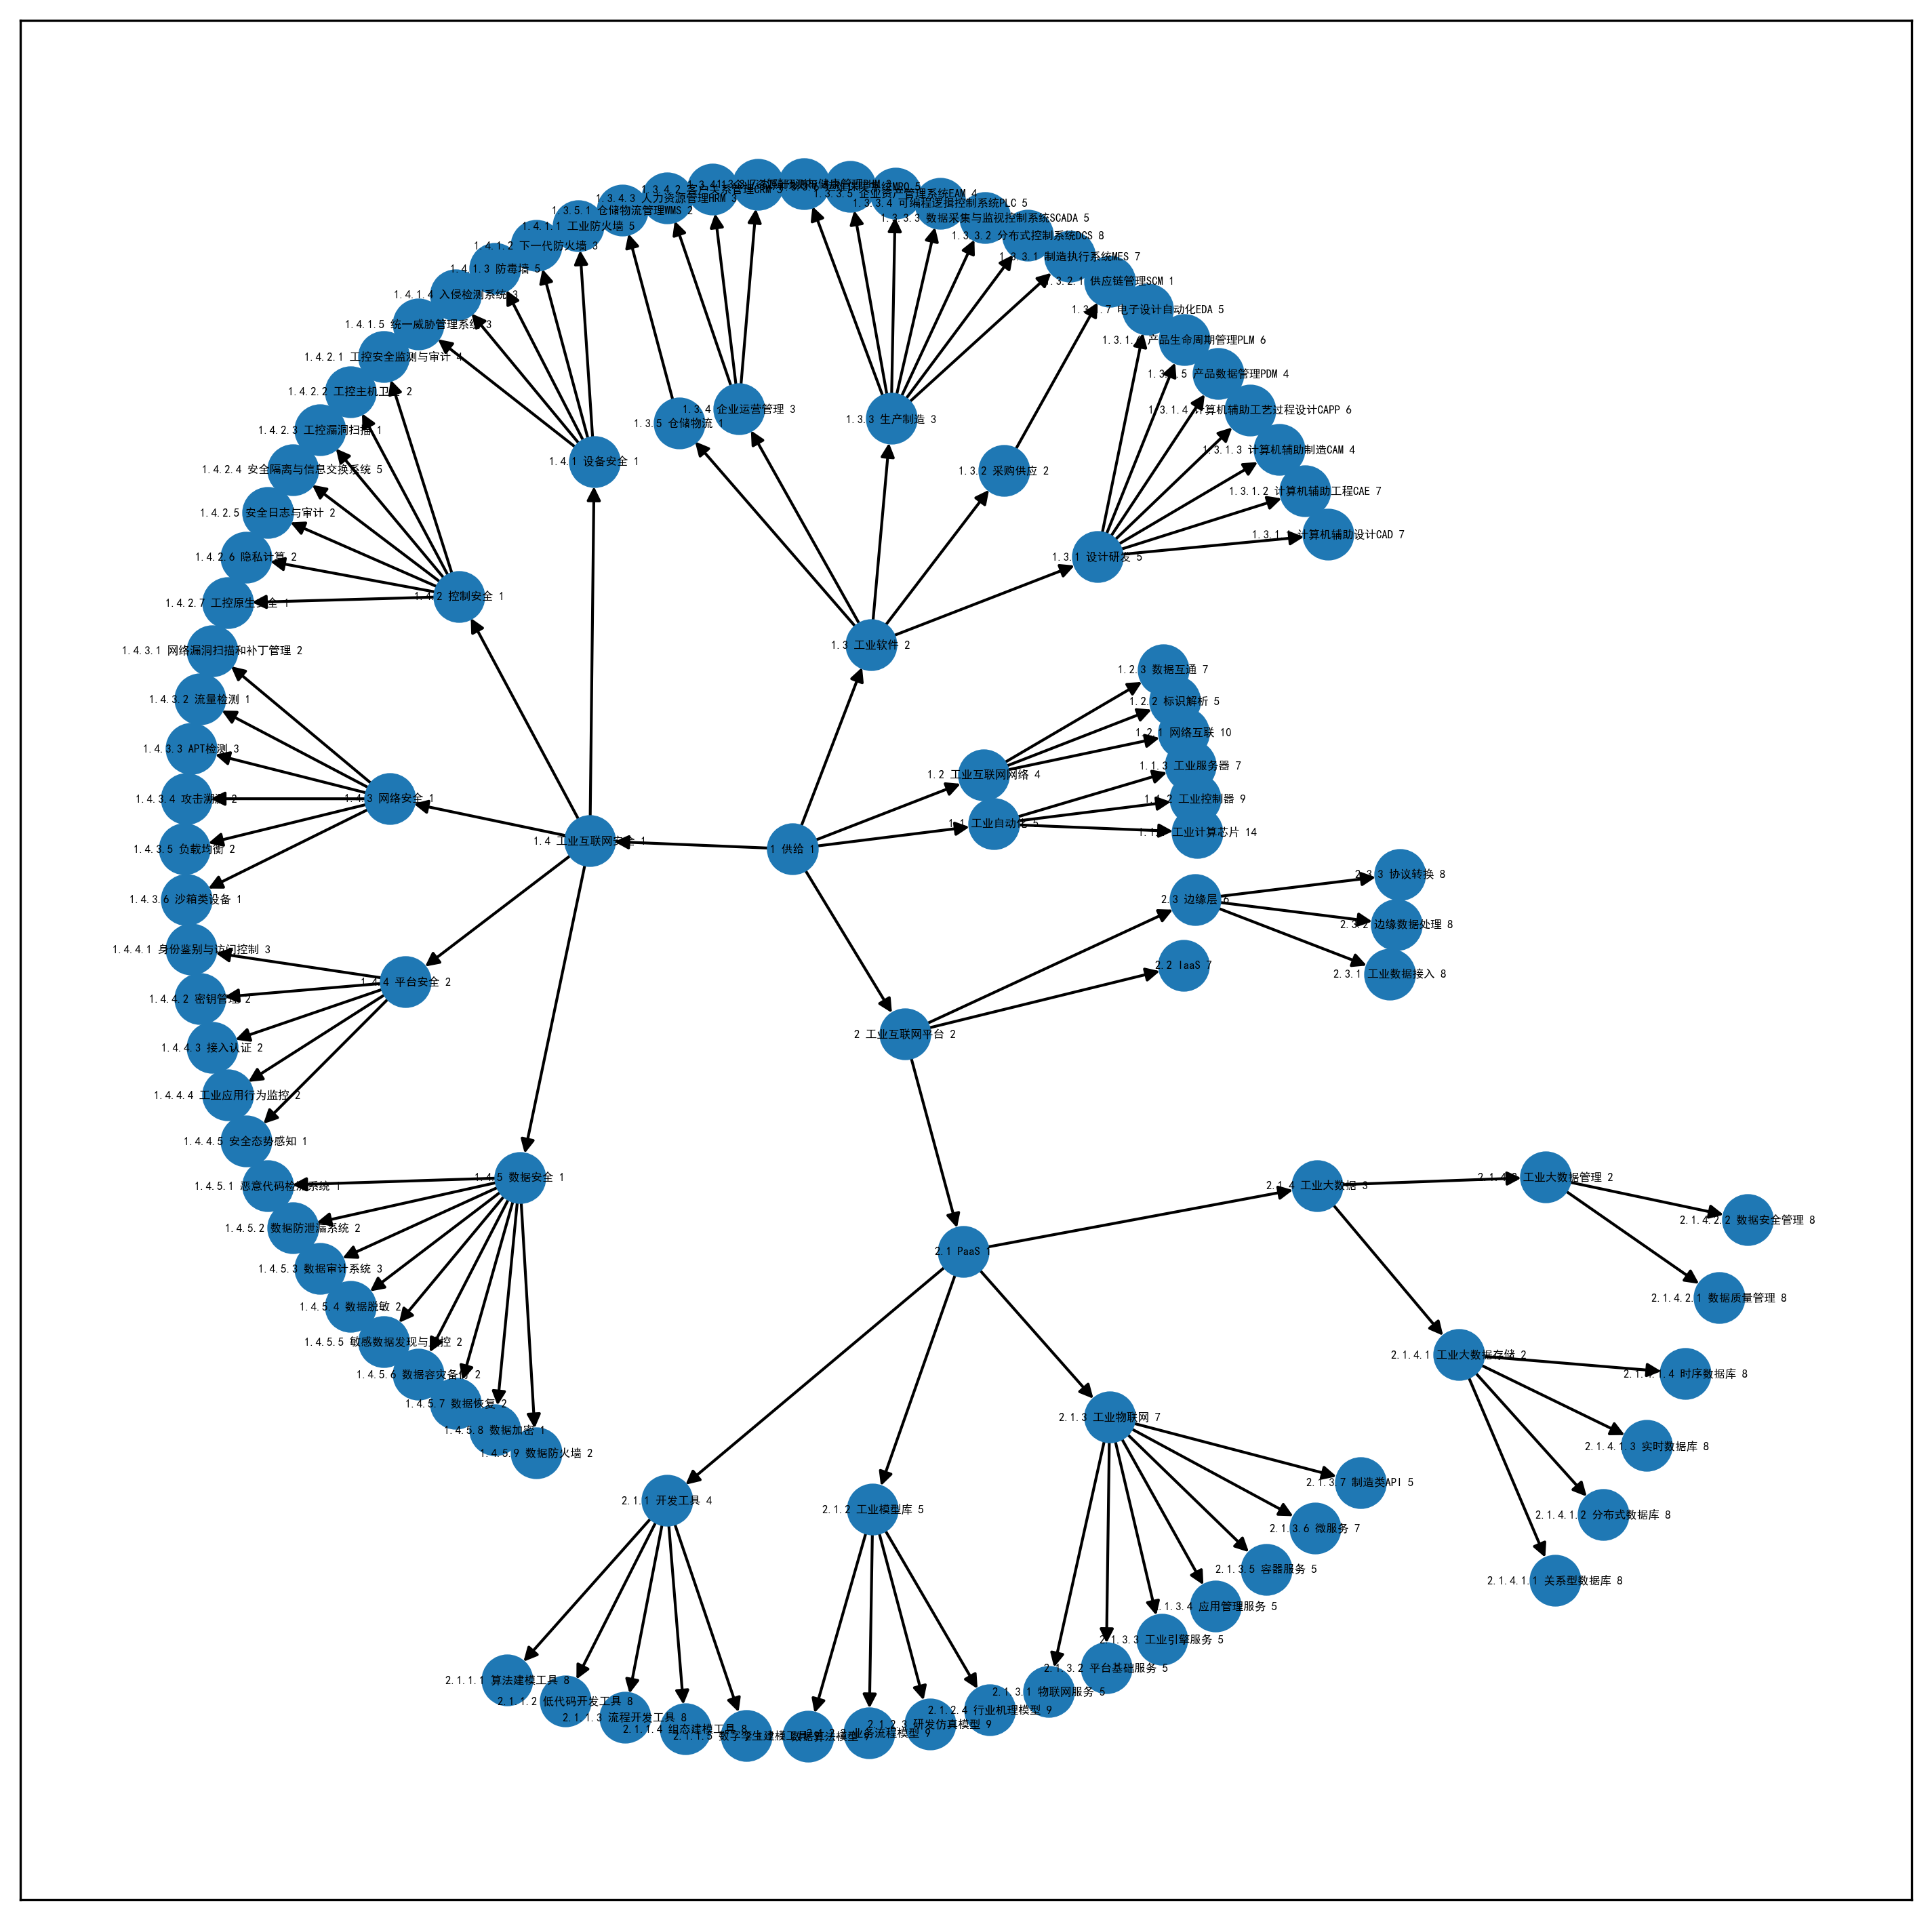

In [5]:
# visualization
pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
dict_num_firm = nx.get_node_attributes(G, 'Num_Firm')
dict_node_name = nx.get_node_attributes(G, 'Name')
node_labels = {}
for node in nx.nodes(G):
    node_labels[node] = f"{node} {str(dict_node_name[node])} {str(dict_num_firm[node])}"
    # node_labels[node] = f"{str(dict_num_firm[node])}"
plt.figure(figsize=(12, 12), dpi=300)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels = node_labels, font_size=4)
plt.show()

0       7393.0
1        171.0
2        113.0
3         24.0
4        242.0
        ...   
165       60.0
166      292.0
167    13371.0
168     5057.0
169     5173.0
Name: Num_Employ, Length: 129, dtype: float64


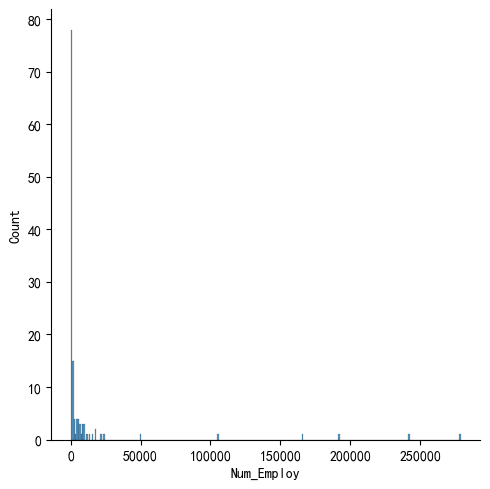

In [3]:
import seaborn as sns
data = Firm_copy[Firm_copy['Num_Employ'] > 0]['Num_Employ']
print(data)
sns.displot(data)

0      1.089000e+10
1      1.380000e+08
6      1.590000e+08
11     6.750000e+08
13     2.470000e+09
           ...     
162    5.880760e+07
167    4.110000e+10
168    4.519000e+09
169    3.470400e+10
170    1.000000e+08
Name: Revenue, Length: 111, dtype: float64


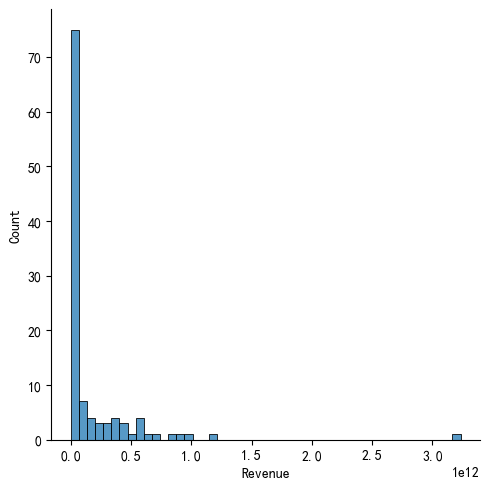

In [4]:
import seaborn as sns
data = Firm_copy[Firm_copy['Revenue'] > 0]['Revenue']
print(data)
sns.displot(data)